# **IMPLEMENTATION OF EDDYSED CODE**
This code is very closely mapped to the eddysed code of Ackerman and Marley from Original Fortran to my implemented Python Version.



### Import necessary python modules


In [199]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Global constants


In [200]:
""" This module defines physical and mathematical constants for atmospheric modeling. Careful for the units! """

MAXNZ = 50 # maximum number of layers
R_Gas = 8.3145e7 # Universal gas constant erg/(K mol)
StefBoltz = 5.6704e-5 # Stefan-Boltzmann constant erg/(cm^2 s K^4)
Avogadro = 6.02214179e23 # Avogadro's number molecules/mol
k_Boltz = 1.38064852e-16 # Boltzmann constant erg/K
Pi = np.pi

# Implementation of read_voyager.f
This code snippet talks about the way the input file from voyager_inputs in the main eddysed code has been handled.


In [201]:
def read_voyager(input_file):

    """
    The input file from voyager_inputs in the main eddysed code.
    reads the following inputs:
    Pressure 
    Temperature
    Gravity
    Effective Temperature
    Number of layers edges

    It calculates the number of layers , effective convective heat flux (chf), 
    molecular weight of atmosphere (assumed constant at 2.2 g/mol), and builds the T and P layers and sub layers along with the creation of altitude layers (Z) and its sub layers.


    and returns the following outputs:

    gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf
    """

    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])+0.5
        gravity = ((float(lines[1]))/100)+0.5
        num_layer_edges = int(lines[2])
        num_layers = num_layer_edges - 1
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
    input_array = np.array(input_data)
    t_layer_edges = input_array[:, 0]
    p_layer_edges = input_array[:, 1]

    r_atmos = 8.3145e7/2.2

    z_layer_edges = np.zeros(num_layer_edges)
    z_layers = np.zeros(num_layers)
    p_layers = np.zeros(num_layers)
    t_layers = np.zeros(num_layers)

    for i in range(num_layers-1, -1, -1):
        itop = i
        ibot = i + 1
        dlnp = np.log(p_layer_edges[ibot]/p_layer_edges[itop])
        p_layers[i] = (p_layer_edges[itop] + p_layer_edges[ibot]) / 2
        scale_height = r_atmos * t_layer_edges[ibot] / gravity
        dz_layer = scale_height * dlnp
        z_layer_edges[i] = z_layers[ibot-1] + dz_layer
        dtdz = (t_layer_edges[itop] - t_layer_edges[ibot]) / dz_layer
        dz_pmid = scale_height * np.log(p_layer_edges[ibot]/p_layers[i])
        z_layers[i] = z_layer_edges[ibot] + dz_pmid
        t_layers[i] = t_layer_edges[ibot] + dtdz * dz_pmid

    chf = StefBoltz * T_eff**4 * np.ones(num_layers) #eqn 21 of Virga Paper where F_rad is assumed to be 0 in convective region

    return gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf

# Read Voyager_lh
This snippet takes the input to run eddysed_lh function

In [202]:
def read_voyager_lh(input_file):

    """
    The input file from voyager_inputs in the main eddysed code.
    reads the following inputs:
    Pressure 
    Temperature
    Gravity
    Effective Temperature
    Number of layers edges

    It calculates the number of layers , effective convective heat flux (chf), 
    molecular weight of atmosphere (assumed constant at 2.2 g/mol), and builds the T and P layers and sub layers along with the creation of altitude layers (Z) and its sub layers.


    and returns the following outputs:

    gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio
    """

    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layer_edges = int(lines[2])
        num_layers = num_layer_edges - 1
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
    input_array = np.array(input_data)
    t_layer_edges = input_array[:, 0]
    p_layer_edges = input_array[:, 1]

    r_atmos = 8.3145e7/2.2

    z_layer_edges = np.zeros(num_layer_edges)
    z_layers = np.zeros(num_layers)
    p_layers = np.zeros(num_layers)
    t_layers = np.zeros(num_layers)
    scale_h = np.zeros(num_layers)
    dlnp_layers = np.zeros(num_layers)
    lapse_ratio = np.zeros(num_layers)

    for i in range(num_layers-1, -1, -1):
        itop = i
        ibot = i + 1
        dlnp = np.log(p_layer_edges[ibot]/p_layer_edges[itop])
        dlnp_layers[i] = dlnp
        p_layers[i] = (p_layer_edges[itop] + p_layer_edges[ibot]) / 2
        scale_height = r_atmos * t_layer_edges[ibot] / gravity
        scale_h[i] = scale_height
        dz_layer = scale_height * dlnp
        z_layer_edges[i] = z_layers[ibot-1] + dz_layer
        dtdz = (t_layer_edges[itop] - t_layer_edges[ibot]) / dz_layer
        dz_pmid = scale_height * np.log(p_layer_edges[ibot]/p_layers[i])
        z_layers[i] = z_layer_edges[ibot] + dz_pmid
        t_layers[i] = t_layer_edges[ibot] + dtdz * dz_pmid
        c_p_factor = 7/2
        lapse_ratio[i] = ( t_layer_edges[ibot] - t_layer_edges[itop] ) / dlnp / ( t_layers[i] / c_p_factor )

    chf = StefBoltz * T_eff**4 * np.ones(num_layers) #eqn 21 of Virga Paper where F_rad is assumed to be 0 in convective region

    return gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio

# Implementation of pvap_gas.f
Here the pressure vapour pressure exerted by the condensate is found in the atmosphere of the planet.


In [203]:
def pvap_gas(gas_name, t_layer, p_layer):
    """ 
    Here we are finding the e_s value for the clasius claperyon equation which is given in A1 eqn of Appendix A in AM01
    the input temperature is in Kelvin.

    Input : Gas name

    Output : e_s value
    """
    if gas_name == "NH3":
        pvap_nh3 = np.exp(-86596/t_layer**2 - 2161/t_layer +10.53)# in dyne/cm^2
        
        return pvap_nh3
    else:
        raise ValueError("Gas not recognized in pvap_gas function.")

In [204]:
def cloud_base(t_layers, p_layers):
    """
    Determine cloud base by finding the first layer moving downward
    where total mixing ratio qt exceeds vapor mixing ratio qv.
    """

    # Total ammonia mixing ratio (AM01 Jupiter)
    qt = 3e-5 * 17/2.2   # (NH3 mass ratio converted to mole ratio)

    for i in range(len(p_layers)-1, -1, -1):

        T = t_layers[i]
        P = p_layers[i]          # P in dyne/cm²?

        # Ensure units match: convert pressure to dyne/cm² if in bar
        if P < 100:              # likely in bar
            P = P * 1e6          # bar → dyne/cm²

        e_s = pvap_gas("NH3", T) # vapor pressure

        # Vapor mixing ratio qv = (μ_NH3 / μ_atm) * e_s / P
        qv = (17/2.2) * (e_s / P)

        if qt > qv:
            qc_at_base = qt - qv
            print("Cloud base found:")
            print(f"Layer index = {i}")
            print(f"T = {T:.2f} K,  P = {P/1e6:.4f} bar")
            print(f"log10(q_c at base) = {np.log10(qc_at_base):.4f}")
            return i, qc_at_base

    print("No cloud base found.")
    return None, None


# Implementation of advdiff.f
This snippet contains the main cloud equation of Ackerman and Marley. The equation talks about the balance between advective and convective current of mixing f molecules.
This function needs to call the v_fall function to pass arguments through it.


In [205]:
def advdiff(qt, ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed):
    """
    calculate divergence from advective-diffusive balance for condensate in a model layer
    Units are in cgs:
    input parameter passed through argument list :
    
    qt      :        total mixing ratio of condensate + vapor (g/g)

    input parameters which are called into the v_fall function:

    ad_qbelow    :   total mixing ratio of vapor in underlying layer (g/g)
    ad_qvs      :    saturation mixing ratio (g/g)
    ad_mixl     :    convective mixing length (cm)
    ad_dz       :    layer thickness (cm) 
    ad_rainf     :   rain efficiency factor 


    Output parameters that come through the v_fall function :

    ad_qc     :      mixing ratio of condensed condensate (g/g)

    """
    ad_qc = max(0.0, qt - ad_qvs) # q_t(z) = q_v(z-dz) paragraph below eqn 1 of AMO1,section 2.1, here instead of q_v , q_t is used as it is used to give a more inclusive approach to suite the entire cloud formation dynamics for more details read the paragraph below figure -1 
    advdiff = ad_qbelow * np.exp(-ad_fsed * ad_qc * ad_dz / (qt*ad_mixl)) - qt # eqn 4 of AM01

    return advdiff

# Implementation of find_root.f
This snippet finds convergence solution between two points which are very close tp each other using the secant method.


In [206]:
def find_root(f, y, params, xlow, xhigh, delta):
    """
    
    find solution to 

    f(x) - y = 0 

    for x between x1 and x2 to within delta using secant method

    Input :
    f : function of x
    y: parameter
    xlow: lower limit of root finding variable
    xhigh : upper limit of root finding variable
    delta : precision of root finding variable
        
    Output :
    xnew : last estimate of root
    status : 0 (for x between x1 and x2 to within  (delta) using secant method when found)
              1 (if maximum number of iterations are reached before convergence)
              -1 (no convergence)
    """
    max_iter = 50 # define maximum number of iterations (user defined)
    epsilon = 1e-7 # define convergence criteria for independent variable (user defined)
    
    # copy input range into local variables
    x1 = xlow
    x2 = xhigh

    # abort if root not bracketed by initial guesses
    f1 = f(x1, *params) - y
    f2 = f(x2, *params) - y

    # default return values
    xnew = x1
    fnew = f1

    if f1*f2 > 0:
        status = -1
        return xnew, status
    
    # iterate until root is found or maximum number of iterations are taken

    iter = 0
    while (np.abs(fnew) > delta) and (iter < max_iter) and (x2/x1 - 1 > epsilon):

        # estimate root from secant between endpoints
        slope = (f2-f1)/(x2-x1)
        xnew = x1 - f1/slope
        fnew = f(xnew, *params) - y

        # pick new x1 and x2 such that f(x) crosses zero between them
        if (fnew*f1 < 0) and (x2/xnew -1 > epsilon):
            x2 = xnew
            f2 = fnew
        else:
            x1 = xnew
            f1 = fnew
        
        iter += 1
    
    # Set status flag accordingly
    if (iter == max_iter) and (x2/x1 - 1 > epsilon):
        status = 1
    else:
        status = 0
    
    return xnew, status



# Implementation of v_fall.f
This code calculates the fallspeed for a spherical particle at one layer of the atmosphere depending on the Reynolds number for Stokes flow.

In [207]:
def vfall(r, vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop):
    """
    calculate fallspeed for a spherical particle at one layer in an
   atmosphere, depending on Reynolds number for Stokes flow.
    For Re_Stokes < 1, use Stokes velocity with slip correction
    For Re_Stokes > 1, use fit to Re = exp( b1*x + b2*x^2 )
     where x = log( Cd Re^2 / 24 )
     where b2 = -0.1 (curvature term) and 
     b1 from fit between Stokes at Re=1, Cd=24 and Re=1e3, Cd=0.45

     
     all units are cgs

    input parameters:
     r : particle radius (cm)

    input parameters through vfall function :
     vf_grav   :     acceleration of gravity (cm/s^2)
     vf_mw_atmos :   atmospheric molecular weight (g/mol)
     vf_mfp    :     atmospheric molecular mean free path (cm)
     vf_visc   :     atmospheric dynamic viscosity (dyne s/cm^2)
     vf_t     :      atmospheric temperature (K)
     vf_p     :      atmospheric pressure (dyne/cm^2)
     vf_rhop  :      density of particle (g/cm^3)

    output : the quantities passed through vfall function

    """
    b1 = 0.8          # Ackerman
    # b1 = 0.86       # Rossow
    # b1 = 0.72       # Carlson
    b2 = -0.01
    cdrag = 0.45      # Ackerman
    # cdrag = 0.2     # Rossow
    # cdrag = 2.0     # Carlson
    
    # calculate vfall based on Knudsen and Reynolds number
    knudsen = vf_mfp / r
    rho_atmos = vf_p / ((R_Gas / vf_mw_atmos) * vf_t)
    drho = vf_rhop - rho_atmos

    # Cunningham correction (slip factor for gas kinetic effects)
    slip = 1 + 1.26*knudsen 

    # Stokes terminal velocity (low Reynolds number)
    vfall = slip*(2/9) * drho * vf_grav * r**2 / vf_visc #B1 of AMO1
    reynolds = 2 * r* rho_atmos * vfall / vf_visc # Paragraph after B2

    if reynolds > 1:

        # correct drag coefficient for turbulence (Re = Cd Re^2 / 24)
        x = np.log(reynolds)
        y = b1*x + b2*x**2
        reynolds = np.exp(y)
        vfall = vf_visc*reynolds / (2 * r * rho_atmos)

        if reynolds > 1000:
            # drag coefficient independent of Reynolds number
            vfall = slip * np.sqrt(8 * drho * r * vf_grav / (3 * cdrag * rho_atmos)) #B3 of AM01

    return vfall

# Implementation of qvs_below.f
This snippet deals with finding the first saturation vapour mixing value for the layer edge (refer to eqn 7 of AM01).

In [208]:
def qvs_below(p_test, qv_dtdlnp, qv_p, qv_t, qv_factor, qv_gas_name):
    """
    Calculate q_vs below  for a gas
    Input :
    p_test : test pressure
    t_test : test temperature
    qv_p  : vapour mixing pressure
    qv_t : vapour mixing temperature
    qv_factor : gas_mw /mw_atmos (assuming supersat =0)
    qv_gas_name : Name of the gas

    output :
    qvs_below : saturation mixing ratio for the first layer edge
    """
    # Extrapolate temperature lapse ratio to test pressure
    t_test = qv_t + np.log(qv_p / p_test) * qv_dtdlnp

    # Compute saturation mixing ratio
    pvap_test = pvap_gas(qv_gas_name, t_test, p_test)
    qvs_below = qv_factor * pvap_test / p_test

    return qvs_below
   

# Implementation of find_rootl.f
This function deals with the find_root in logarithm scale

In [209]:
def find_rootl(f, y, params, xlow, xhigh, delta):
    """
    find solution to :
    log(f(x)) - log(y) = 0
    for x between x1 and x2 to within log (delta) using secant method
    
    Input :
    f : function
    y: parameter
    delta : distance between x1 and x2 in logarithm scale 
    xlow : lower boundary of root finding 
    xhigh: higher boundary of root finding

    Output :
    xnew : last estimate of root
    status : 0 (for x between x1 and x2 to within log (delta) using secant method when found)
              1 (if maximum number of iterations are reached before convergence)
              -1 (no convergence)
    
    """
    max_iter = 50 # define maximum number of iterations
    epsilon = 1e-7 # define convergence criteria for independent variable
    
    # copy input range into local variables
    x1 = xlow
    x2 = xhigh

    # abort if root not bracketed by initial guesses
    f1 = np.log(f(x1, *params)) - np.log(y)
    f2 = np.log(f(x2, *params)) - np.log(y)

    # default return values
    xnew = x1
    fnew = f1

    if f1*f2 > 0:
        status = -1
        return xnew, status
    
    # take log for precision
    delta = np.log(delta)
    
    # iterate until root is found or maximum number of iterations are taken

    iter = 0
    while (np.abs(fnew) > delta) and (iter < max_iter) and (x2/x1 - 1 > epsilon):

        # estimate root from secant between endpoints
        slope = (f2-f1)/(x2-x1)
        xnew = x1 - f1/slope
        fnew = np.log(f(xnew, *params)) - np.log(y)

        # pick new x1 and x2 such that f(x) crosses zero between them
        if (fnew*f1 < 0) and (x2/xnew -1 > epsilon):
            x2 = xnew
            f2 = fnew
        else:
            x1 = xnew
            f1 = fnew
        
        iter += 1
    
    # Set status flag accordingly
    if (iter == max_iter) and (x2/x1 - 1 > epsilon):
        status = 1
    else:
        status = 0
    
    return xnew, status

# Implementation of calc_qc.f

This code snippet is about the implementation of the calc_qc function where the condensate mixing ratio is calculated and r_g and r_eff and number of droplet concentration is also calculated

This function requires to call the find_root, v_fall and advdiff to be called in to be executed properly.

In [ ]:
def calc_qc(gas_name, f_sed_layer, rho_p, mw_cloud, q_below, supsat, w_convect, mixl, dz_layer, gravity, mw_atmos, mfp, visc, t_layer, p_layer, sig_layer):

    """
    Calculate the condensate mixing ratio and the total mixing ratio along with the droplet effective and geometric mean radius along with coloumn droplet number concentration in a single atmospheric layer 
    
    Inputs :
    gas_name  :   name of condensing vapor
    f_sed_layer : rain factor for layer
    rho_p      :  density of condensed vapor (g/cm^3)
    mw_cloud  :  molecular weight of condensing vapor (g/mol)
    q_below    : total mixing ratio (vapor+condensate) below layer (g/g)
    supsat    :  fractional supersaturation persisting after condensation (assumed to be 0)
    w_convect   :convective velocity scale (cm/s)
    mixl       : convective mixing length scale (cm)
    dz_layer    :thickness of layer (cm)
    grav       : gravitational acceleration (cm/s^2)
    mw_atmos  :  molecular weight of atmosphere (g/mol)
    mfp  :       atmospheric mean free path (cm)
    visc :       atmospheric dynamic viscosity (dyne s/cm^2)
    t_layer  :   temperature of layer mid-pt (K)
    p_layer  :   air pressure (dyne/cm^2)
    sig_layer  : geometric std. dev. of lognormal size distribution


    Outputs :

    qc_layer :   condensate mixing ratio (g/g)
    qt_layer  :  gas + condensate mixing ratio (g/g)
    rg_layer :   geometric mean radius of condensate (cm)
    reff_layer : effective (area-weighted) radius of condensate (cm)
    ndz_layer  : column of particle concentration in layer (#/cm^2)
    qt_top   :   top of layer
    status_r  :  error status for finding rw
    status_q :   error status for finding qt
    
    
    
    We need to call the v_fall ,find_root and advdiff functions inside this function. to solve for qc, qt, rw, reff , rg and ndz.
    1. advdiff : to solve for qt at the top of the layer
    2. vfall : to solve for rw given w_convect
    3. find_root : to find roots of advdiff and vfall functions.
    4. using trapezoid rule to calculate layer averages of qt.
    5. diagnose qc from qt and qvs.
    6. calculate rg, reff and ndz using the diagnosed qc and rw.
    7. return all the calculated values.
    """

    pvap = pvap_gas(gas_name, t_layer, p_layer)
    fs = supsat + 1
    rho_atmos = p_layer / (R_Gas/mw_cloud * t_layer)
    qvs = fs * pvap / (R_Gas/mw_atmos * t_layer) / rho_atmos
    


    # Layer is cloud free
    if q_below < qvs:
        
        qt_layer = q_below
        qt_top = q_below
        qc_layer = 0.0
        rg_layer = 0.0
        reff_layer = 0.0
        ndz_layer = 0
        status_q = 0
        status_r = 0

    # Layer has cloud
    else:
        
        # range of mixing ratios to search (g/g)
        qhigh = q_below
        qlow = qhigh * 0.001

        # precision of advective diffusive solution (g/g)
        delta_q = q_below *0.001

        # load paramaters into advdiff common block
        ad_qbelow = q_below
        ad_qvs = qvs
        ad_mixl = mixl
        ad_dz = dz_layer
        ad_fsed = f_sed_layer
        params = (ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed)

        # Find total condensate mixing ratio at the top of the layer
        qt_top, status_q = find_root(advdiff, 0.0, params, qlow, qhigh, delta_q)

        # Use trapezoid rule to calculate layer averages
        # -- should integrate exponential
        qt_layer = 0.5 * (q_below + qt_top)

        # Diagnose condensate mixing ratio
        qc_layer = max(0.0, qt_layer - qvs)

        # Find rw corresponding to w_convect using function vfall()

        # load parameters into vfall common block
        vf_grav = gravity
        vf_mw_atmos = mw_atmos
        vf_mfp = mfp
        vf_visc = visc
        vf_p = p_layer
        vf_t = t_layer
        vf_rhop = rho_p
        vf_params = (vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop)

        # range of particle radii to search (cm)
        rlow = 1e-10
        rhigh = 10

        # precision of terminal velocity solution (cm/s)
        delta_v = w_convect / 1000
        rw_layer, status_r = find_root(vfall, w_convect, vf_params, rlow, rhigh, delta_v)
        

        # geometric std dev of lognormal size distribution
        lnsig2 = 0.5*np.log( sig_layer )**2

        # Compute exponent in vfall = w_convect r^alpha
        # sigma floor  for the purpose of alpha calculation
        sig_alpha = max(1.1, sig_layer)
        
        # Bulk of precip at r > rw: exponent between rw and rw*sig
        if f_sed_layer > 1:
            alpha = np.log(vfall(rw_layer * sig_alpha, *vf_params) / w_convect) / np.log(sig_alpha)
        
        # Bulk of precip at r < rw: exponent between rw/sig and rw
        else:
            alpha = np.log(w_convect / vfall(rw_layer / sig_alpha, *vf_params)) / np.log(sig_alpha)
        
        # geometric mean radius of lognormal size distribution
        rg_layer = f_sed_layer**(1/alpha) * rw_layer * np.exp(-(alpha+6)*lnsig2) #eqn 13 of AM01

        # droplet effective radius (cm)
        reff_layer = rg_layer * np.exp(5*lnsig2) #eqn 17 of AM01

        # Column droplet number concentration (cm^-2)
        ndz_layer = 3.0 * rho_atmos * qc_layer * dz_layer / ((4.0 * Pi * rho_p * rg_layer**3 )* np.exp(-9 * lnsig2))

    return qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, qt_top, status_r, status_q

# Implementation of layer.f

This code snippet works on the layer function of the code and calculates optical depth until a convergent solution to it is found.
This code snippet works on the layer function of the code and calculates optical depth until a convergent solution to it is found. The kz is also calculated using the Gierasch & Conrath formula over her itself

This function calls in the calc_qc function to be executed properly.


In [213]:
def layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud, mw_atmos, f_sed, rho_p, supsat, sig_layer, t_layer, p_layer, t_top, t_bot, p_top, p_bot, chf_layer, gravity, q_below, report_status_r, report_status_q):

    """ 
    Calculating layer condensate properties by iterating on optical depth until converges in one model layers (convergence on optical depth in sublayers)

    Inputs :
    nsub_max :   maximum number of sublayers for mesh refinement
    gas_name  :  name of condensing vapor
    kz_min :     minimum eddy diffusion coefficient (cm^2/s)
    cloudf_min :  minimum cloud fractional coverage
    mw_cloud  :  molecular weight of condensate (g/mol)
    rainf  :     rain factor
    rho_p  :     density of condensed vapor (g/cm^3)
    supsat  :    fractional supersaturation persisting after condensation
    sig_layer :   geometric std deviation of lognormal size distribution
    t_layer :    temperature at layer mid-pt (K)
    p_layer :    pressure at layer mid-pt (dyne/cm^2)
    t_top,bot :  temperature at top and bottom of layer (K)
    p_top,bot :  pressure at top and bottom of layer (dyne/cm^2)
    chf_layer : convective heat flux at the layer
    gravity :  gravity of the planet
    q_below : first layer edge saturation vapour pressure
    

    Outputs :
    qc_layer :   condensate mixing ratio (g/g)
    qt_layer  :  gas + condensate mixing ratio (g/g)
    rg_layer  :  geometric mean radius of condensate (cm)
    reff_layer : effective (area-weighted) radius of condensate (cm)
    ndz_layer  : column of particle concentration in layer (#/cm^2)
    opd_layer :  optical depth for conservative geometric scatterers

    report_status_r :   report error status for finding rw
    report_status_q :   report error status for finding qt

    This function calls calc_qc to calculate the condensate mixing ratio and other properties in the layer by subdividing the layer into sublayers and iterating until convergence on optical depth is achieved.



    """

    # Set error return codes to zero
    status_r = 0
    status_q = 0

    # Number of levels of grid refinement used 
    nsub = 1

    # diameter of atmospheric molecule (cm) (Rosner, 2000)
    # (3.711e-8 for air, 3.798e-8 for N2, 2.827e-8 for H2)
    d_molecule = 2.827e-8

    # parameter in Lennard-Jones potential for viscosity (K) (Rosner, 2000)
    # (78.6 for air, 71.4 for N2, 59.7 for H2)
    eps_k = 59.7

    # specific gas constant for atmosphere (erg/(g K))
    r_atmos = R_Gas / mw_atmos

    # specific heat of atmosphere (erg/K/g)
    c_p = 7./2. * r_atmos

    # pressure thickness of layer
    dp_layer = p_bot - p_top
    dlnp = np.log( p_bot/p_top )

    # temperature gradient 
    dtdlnp = ( t_top - t_bot ) / dlnp
    lapse_ratio = ( t_bot - t_top ) / dlnp / ( 2./7.*t_layer )

    # atmospheric density (g/cm^3)
    rho_atmos = p_layer / ( r_atmos * t_layer )

    # atmospheric scale height (cm)
    scale_h = r_atmos * t_layer / gravity #below eqn 5 in AM01

    # convective mixing length scale (cm): no less than 1/10 scale height
    mixl = max( 0.1, lapse_ratio ) * scale_h

    # mixing length = scale height matches Lunine (1989) model
    # mixl = scale_h

    # scale factor for eddy diffusion: 1/3 is baseline
    scalef_kz = 1./3.

    # vertical eddy diffusion coefficient (cm^2/s)
    # from Gierasch and Conrath (1985)
    kz = scalef_kz * scale_h * (mixl/scale_h)**(4/3) *( ( r_atmos*chf_layer) / ( rho_atmos*c_p ) )**(1/3) # eqn 5 in AM01

    # no less than minimum value (for radiative regions)
    kz_layer = max( kz, kz_min )

    # convective velocity scale (cm/s)
    w_convect = kz_layer / mixl

    # cloud fractional coverage
    cloudf = cloudf_min + max( 0, min( 1, 1-lapse_ratio )) * ( 1 - cloudf_min )

    # atmospheric number density (molecules/cm^3)
    n_atmos = p_layer / ( k_Boltz*t_layer )

    # atmospheric mean free path (cm)
    mfp = 1. / ( np.sqrt(2.)*n_atmos*Pi*d_molecule**2 )

    # atmospheric viscosity (dyne s/cm^2)
    visc = 5./16.*np.sqrt( Pi*k_Boltz*t_layer*(mw_atmos/Avogadro)) / ( Pi*d_molecule**2 ) / ( 1.22 * ( t_layer / eps_k )**(-0.16) )
    # Eqn. B2 in Appendix B of AM01
    # --------------------------------------------------------------------
    # Top of convergence layer
    
    converge = False
    while not converge:
        
        # Zero cumulative values
        qc_layer = 0
        qt_layer = 0
        ndz_layer = 0
        opd_layer = 0

        # total mixing ratio and pressure at the bottom of sub layer
        qt_bot_sub = q_below
        p_bot_sub = p_bot

        # Loop over sub layers
        dp_sub = dp_layer / nsub
        for isub in range(nsub):

            qt_below = qt_bot_sub
            p_top_sub = p_bot_sub - dp_sub
            dz_sub = scale_h * np.log( p_bot_sub / p_top_sub )
            p_sub = ( p_bot_sub + p_top_sub ) / 2
            t_sub = t_bot + dtdlnp * np.log( p_bot / p_sub )

            # Calculate condensate mixing ratio etc. for sub layer
            qc_sub, qt_sub, rg_sub, reff_sub, ndz_sub, qt_top, status_r, status_q = calc_qc(gas_name, f_sed, rho_p, mw_cloud, qt_below, supsat, w_convect, mixl, dz_sub, gravity, mw_atmos, mfp, visc, t_sub, p_sub, sig_layer)

            # Vertical sums
            qc_layer += qc_sub * dp_sub/gravity
            qt_layer += qt_sub * dp_sub/gravity
            ndz_layer += ndz_sub

            if reff_sub > 0:
                opd_layer += 1.5 * qc_sub * dp_sub / gravity / (rho_p * reff_sub)
            
            # Increment values at the bottom of the sub layer
            qt_bot_sub = qt_top
            p_bot_sub = p_top_sub
        
            # Check convergence on optical depth
            if nsub_max > 1:
                converge = True
            elif nsub == 1:
                opd_test = opd_layer
            elif (opd_layer > 0) or (nsub >= nsub_max):
                converge = True
            elif np.abs(1 - opd_test/opd_layer) < 0.01:
                converge = True
            else:
                opd_test = opd_layer
            
            nsub = nsub * 2
        
        # --------------------------------------------------------------------
        # Bottom of convergence layer

        # Report problems finding the root first time it happens
        if (status_r != 0) and report_status_r:
            print("layer():")
            print(f" find_root(vfall) status = {status_r:3d} for {gas_name} at p = {p_layer/1e6:10.2e}")
            print("There may be more instances not reported")
            print("")
            print(f"status_r = {status_r:3d}")
            report_status_r = False
        
        if (status_r != 0) and report_status_q:
            print("layer():")
            print(f" find_root(advdiff) status = {status_q:3d} for {gas_name} at p = {p_layer/1e6:10.2e}")
            print(" there may be more instances not reported")
            print()
            print(f"status_q = {status_q}")
            report_status_q = False

        # Update properties at the bottom of next layer
        q_below = qt_top

        # Get layer averages

        if opd_layer > 0:
            reff_layer = 1.5 * qc_layer / (rho_p * opd_layer)
            lnsig2 = 0.5 * np.log( sig_layer )**2
            rg_layer = reff_layer * np.exp(-5 * lnsig2)
        else:
            reff_layer = 0.0
            rg_layer = 0.0

        qc_layer = qc_layer * gravity/dp_layer
        qt_layer = qt_layer * gravity/dp_layer

    return qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q

# Implementation of eddysed.f
This is the main eddysed block of the code. Here we are finally get our desired output of q_c which is the condenste mass mixing ratio. Here a virtual layer is added to counteract the problem of convergence of the solution and if the condensable condenses before the periphery of the model grid.
This function calls the find_rootl function and pvap_gas function to be executed properly.

In [214]:
def eddysed(gravity, T_eff, kz_min, cloudf_min, nsub_max, supsat, mw_atmos, do_virtual, num_layers, z_layers, z_layer_edges, p_layers, p_layer_edges, t_layers, t_layer_edges, chf, gas_name, gas_mmr, gas_mw, rho_p, sig, f_sed):
    
    """
    Main driver for EddySed cloud model
    Given atmospheric profiles and cloud parameters, calculate size and concentration of condensates in each layer of the atmosphere.

    Input Scalars :
    gravity   :      gravitational acceleration (cm/s^2)
    T_eff    :     effective temperature (K)
    kz_min   :    minimum eddy diffusion coefficient (cm^2/s)
    cloudf_min :   minimum cloud fractional coverage
    nsub_max  :   maximum number of sublayers for adaptive mesh refinement
    supsat   :    supersaturation after condensation (fraction)
    mw_atmos   :  molecular weight of atmosphere (g/mol)
    do_virtual :  reduce mixing ratio due to decrease below cloud base
    num_layers : number of layers
 

    
    Input Vectors:
    z_layers     :       altitude at layer mid-pt (by pressure) (cm)
    z_layer_edges  :      altitude at top of layer (cm)
    p_layers     :      pressure at layer mid-pt (by pressure) (dyne/cm^2)
    p_layer_edges  :      pressure at top of layer (dyne/cm^2)
    t_layers    :       temperature at layer mid-pt (by pressure) (K)
    t_layer_edges  :      temperature at top of layer (K)
    chf     :     layer convective heat flux (erg/s/cm^2)
    gas_name  :   names of condensing gases
    gas_mmr  :    mass mixing ratio of gas below cloud base (g/g)
    gas_mw  :     molecular weight of gas (g/mol)
    rho_p   :     density of condensed vapor (g/cm^3)
    sig     :     geometric std deviation of lognormal size distribution
    f_sed :      ratio of microphysical sed flux to eddy sed flux

    Output Vectors:
    kz   :        eddy diffusion coefficient (cm^2/s)
    qt    :       total (gas+condensed) mixing ratio of condensate (g/g)
    qc :           mixing ratio of condensed condensate (g/g)
    ndz  :        number column density of condensate (cm^-3)
    rg  :          geometric mean radius of lognormal size distribution
    reff :        droplet effective radius (second moment of size distrib, cm)
   
    """

    # Initialization:
    cloud_base = 0
    report_status_r = True
    report_status_q = True

    # Calculate indices of bottom and top of domain
    if z_layers[1] > z_layers[0]:
        i_bottom = 0
        i_top = num_layers - 1
        k_bottom = 0
        k_top = num_layers - 1
        increment = 1
    else:
        i_bottom = num_layers - 1
        i_top = 0
        k_bottom = num_layers
        k_top = 1
        increment = -1

    # Start at the bottom  of the domain: get p, T and qt
    t_bot = t_layer_edges[k_bottom]
    p_bot = p_layer_edges[k_bottom]
    q_below = gas_mmr

    # Initialize vertical path of condensate qc_path to zero
    qc_path = 0

    # Adjust mixing ratio at bottom of model domain if bottom layer is saturated
    if do_virtual:
        qvs_factor = (supsat+1) * gas_mw /mw_atmos
        pvap = pvap_gas(gas_name, t_bot, p_bot)
        qvs = qvs_factor * pvap / p_bot
        # eqn 3.62 from the book Atmospheric Survey by Walllace and Hobbs, the equation of q_vs to be alterred according to chemistry of the planet
        # e_s is the pvap function in the code which is taken from appendix A of AM01 eqn A1
        
        if qvs <= q_below:

            # Find pressure at cloud base

            # parameters for root finding
            p_low = p_bot
            p_high = p_bot * 100
            delta_q = q_below / 100

            # temperature gradient
            dtdlnp = ( t_layer_edges[k_bottom + increment] - t_bot)/ np.log( p_bot / p_layer_edges[k_bottom + increment] )

            # load parameters into qvs_below common block
            qv_dtdlnp = dtdlnp
            qv_p = p_bot
            qv_t = t_bot
            qv_gas_name = gas_name
            qv_factor = qvs_factor
            qv_params = (qv_dtdlnp, qv_p, qv_t, qv_factor, qv_gas_name)

            p_base, status_p = find_rootl(qvs_below, q_below, qv_params, p_low, p_high, delta_q)

            if status_p != 0:
                print("Unable to find cloud base pressure in eddysed():")
                print(f"find_rootl(qvs_below) status = {status_p} for {gas_name}")

            t_base = t_bot + dtdlnp * np.log( p_bot / p_base )

            # Calculate temperature and pressure below bottom layer by adding a virtual layer
            p_layer = (p_bot + p_base) / 2
            t_layer = t_bot + dtdlnp * np.log( p_bot / p_layer )

            # Calculate qc, qt, rg, reff and ndz for virtual layer
            qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q = layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud=gas_mw, mw_atmos=mw_atmos, f_sed=f_sed, rho_p=rho_p, supsat=supsat, sig_layer=sig[i_bottom], t_layer=t_layer, p_layer=p_layer, t_top=t_base, t_bot=t_bot, p_top=p_base, p_bot=p_bot, chf_layer=chf[i_bottom], gravity=gravity, q_below=q_below, report_status_r=report_status_r, report_status_q=report_status_q)

            # report optical depth below domain
            print(f"eddysed(): Condensing gas = {gas_name}")
            print(f"cloud base at p, T = {p_base/1e6:10.2e}, {t_base:8.2f}")
            opd_belowdomain = 1.5 * qc_layer * (p_base - p_bot) / gravity / (rho_p * reff_layer)
            print(f"optical depth below domain = {opd_belowdomain:10.4e}")

    qc = np.zeros(num_layers)
    qt = np.zeros(num_layers)
    rg = np.zeros(num_layers)
    reff = np.zeros(num_layers)
    ndz = np.zeros(num_layers)
    kz = np.zeros(num_layers)

    # Loop over atmospheric layers from the bottom up
    for i_layer in range(i_bottom, i_top + increment, increment):
        if increment == 1:
            k_layer = i_layer
        else:
            k_layer = i_layer + 1
        
        qc_layer, qt_layer, rg_layer, reff_layer, ndz_layer, opd_layer, kz_layer, report_status_r, report_status_q = layer(nsub_max, gas_name, kz_min, cloudf_min, mw_cloud=gas_mw, mw_atmos=mw_atmos, f_sed=f_sed, rho_p=rho_p, supsat=supsat, sig_layer=sig[i_layer], t_layer=t_layers[i_layer], p_layer=p_layers[i_layer], t_top=t_layer_edges[k_layer + increment], t_bot=t_layer_edges[k_layer], p_top=p_layer_edges[k_layer + increment], p_bot=p_layer_edges[k_layer], chf_layer=chf[i_layer], gravity=gravity, q_below=q_below, report_status_r=report_status_r, report_status_q=report_status_q)

        qc[i_layer] = qc_layer
        qt[i_layer] = qt_layer
        rg[i_layer] = rg_layer
        reff[i_layer] = reff_layer
        ndz[i_layer] = ndz_layer
        kz[i_layer] = kz_layer

        # Accumulate vertical path of condensate
        qc_path += qc_layer * ( p_layer_edges[k_layer] - p_layer_edges[k_layer + increment] ) / gravity

    # Print some diagnostics
    print(f"eddysed(): condensing gas = {gas_name}")
    print(f"condensate path = {qc_path*1e4} g/m^2")

    return kz, qt, qc, ndz, rg, reff

# Implementation of eddysed_lh.f
This snippet calculates the q_c values when latent heat is turned on and w* convect is solved as a cubic equation. It calls in the advidiff and vfall function but it does not required the calc _qc function to be called to run this code effectively.

In [215]:
def eddysed_lh(gravity, T_eff, num_layers, sig, f_sed, z_layers, p_layers, t_layers, dlnp, chf, lapse_ratio, gas_name, gas_mmr, mw_atmos, rho_p):
    """
    Input :
    Gravity : Gravitataional Acceleration of the planet (cms^-2)
    T_eff : Effective Temperature (K)
    num_layers : Number of layers

    sig: gemoteric deviation of logarithmic size distribution taken as 2 here

    f_sed : sedimentation efficiency
    z_layers : layers of altitude
    p_layers : layers of pressure
    t_layers :layers of temperature
    dlnp : ln (p1) -ln (p2) = ln(bottom/top) pressures at bottom and top of each layer edges
    chf : Convctive heat flux
    lapse-ratio : ratio of lapse rate within a layer to adiabatic lapse rate
    gas_name : Name of gas condensing
    gas_mmr : mass mixing ratio of condensing gas (g/mol)


    Output :
    kz : eddy diffuion coefficient (cm^2/s)
    lhf : total latent heat flux (erg/s/cm^2)
    qt : total (gas+condensed) mixing ratio of condensate (g/g)
    qc :  mixing ratio of condensed condensate (g/g)
    ndz : number column density of condensate (cm^-3)
    rg : geometric mean radius of lognormal size distribution
    reff:  droplet effective radius (second moment of size distrib, cm)
    rw : fall radius (cm)


    


    """
    
    
    
    
    d_molecule = 2.827e-8
    eps_k = 59.7
    r_atmos = R_Gas/mw_atmos
    c_p = 7/2 * r_atmos

    cloud_base = 0.0

    supsat = 0.0
    fs = supsat + 1

    # Calculate indices of bottom and top of domain
    if z_layers[1] > z_layers[0]:
        i_bottom = 1
        i_top = num_layers -1
        increment = 1
    else:
        i_bottom = num_layers -1
        i_top = 1
        increment = -1

    qc = np.zeros(num_layers)
    qt = np.zeros(num_layers)
    rw = np.zeros(num_layers)
    rg = np.zeros(num_layers)
    reff = np.zeros(num_layers)
    ndz = np.zeros(num_layers)
    kz = np.zeros(num_layers)
    dz = np.zeros(num_layers)
    mixl = np.zeros(num_layers)
    lhf = np.zeros(num_layers)

    # Loop over atmospheric layers from the bottom up
    for i_layer in range(i_bottom, i_top + increment, increment):
        rho_atmos = p_layers[i_layer] / (r_atmos * t_layers[i_layer])

        scale_h = r_atmos * t_layers[i_layer] / gravity

        dz[i_layer] = scale_h * dlnp[i_layer]

        mixl[i_layer] = max(0.1, lapse_ratio[i_layer]) * scale_h

        n_atmos = p_layers[i_layer] / (k_Boltz * t_layers[i_layer])

        mfp = 1 / (np.sqrt(2) * n_atmos * Pi * d_molecule**2)

        visc = 5/16 * np.sqrt(Pi * k_Boltz * t_layers[i_layer] * (mw_atmos/Avogadro)) / (Pi * d_molecule**2) / (1.22 * (t_layers[i_layer]/eps_k)**(-0.16))

        t_layer = t_layers[i_layer]
        p_layer = p_layers[i_layer]

        rlow = 1e-10
        rhigh = 10

        lh_sum = 0

        mw_cloud = 17
        pvap = pvap_gas(gas_name, t_layer, p_layer)
        lh = 28.6e10

        qvs = fs*pvap / ((R_Gas/mw_cloud) * t_layer) / rho_atmos

        if i_layer == i_bottom:
            q_below = gas_mmr
            zdiff = dz[i_layer]/2
        else:
            q_below = qt[i_layer - increment]
            zdiff = z_layers[i_layer] - z_layers[i_layer - increment]

        if q_below < qvs:
            qt[i_layer] = q_below
            qc[i_layer] = 0
            rg[i_layer] = 0
        
        else:
            f_sed_layer = f_sed
            mixl_layer = mixl[i_layer]

            qhigh = q_below
            qlow = qhigh / 1000

            delta_q = q_below / 1000

            # load paramaters into advdiff common block
            ad_qbelow = q_below
            ad_qvs = qvs
            ad_mixl = mixl_layer
            ad_dz = dz[i_layer]
            ad_fsed = f_sed_layer
            params = (ad_qbelow, ad_qvs, ad_mixl, ad_dz, ad_fsed)

            # Find total condensate mixing ratio at the top of the layer
            qt_layer, status_q = find_root(advdiff, 0.0, params, qlow, qhigh, delta_q)

            if status_q != 0:
                print(f"find_root(advdiff) status = {status_q} for {gas_name} at altitude = {z_layers[i_layer]}")

            qt[i_layer] = qt_layer
            qc[i_layer] = max(0.0, qt_layer - qvs)

            lh_sum = lh_sum + f_sed_layer * qc[i_layer] * lh / (mw_cloud * c_p /r_atmos)
    
        coeff_a = lh_sum
        coeff_b = - chf[i_layer] / (rho_atmos * c_p / r_atmos)

        if lh_sum == 0:
            w_convect = (-coeff_b)**(1/3)
        else:
            cubic_arg = coeff_b**2 / 4 + coeff_a**3 / 27
            w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)

        lhf[i_layer] =1e-3* w_convect * lh_sum * rho_atmos * c_p / r_atmos

        kz[i_layer] = w_convect * mixl[i_layer]

        if qc[i_layer] > 0:

            if cloud_base == 0:
                cloud_base = i_layer
            
            # load parameters into vfall common block
            vf_grav = gravity
            vf_mw_atmos = mw_atmos
            vf_mfp = mfp
            vf_visc = visc
            vf_p = p_layer
            vf_t = t_layer
            vf_rhop = rho_p
            vf_params = (vf_grav, vf_mw_atmos, vf_mfp, vf_visc, vf_t, vf_p, vf_rhop)

            # range of particle radii to search (cm)
            rlow = 1e-10
            rhigh = 10

            # precision of terminal velocity solution (cm/s)
            delta_v = w_convect / 1000
            rw_layer, status_r = find_root(vfall, w_convect, vf_params, rlow, rhigh, delta_v)

            if status_r != 0:
                print(f"find_root(vfall) status = {status_r} for {gas_name} at i_layer, altitude, r = {i_layer, z_layers[i_layer], rw_layer}")
            
            rw[i_layer] = rw_layer
            
            lnsig2 = 0.5 * np.log(sig[i_layer])**2

            sig_alpha = max(1.1, sig[i_layer])

            if f_sed_layer > 1:
                alpha = np.log(vfall(rw_layer* sig_alpha, *vf_params) /w_convect) / np.log(sig_alpha)
            else:
                alpha = np.log(w_convect / vfall(rw_layer / sig_alpha, *vf_params)) / np.log(sig_alpha)

            rg[i_layer] = f_sed_layer**(1/alpha) * rw_layer * np.exp(-(alpha+6)*lnsig2)

            reff[i_layer] = rg[i_layer] * np.exp(5 * lnsig2)

            ndz[i_layer] = 3 * rho_atmos * qc[i_layer] * dz[i_layer] / (4 * Pi * rho_p * rg[i_layer]**3) * np.exp(-9 * lnsig2)

        else:
            rg[i_layer] = 0
            reff[i_layer] = 0
            ndz[i_layer] = 0
        
        if i_layer == cloud_base:
            
            opd_expect = 1.5 * gas_mmr * p_layers[i_layer] / (gravity * (f_sed_layer + 1) * reff[i_layer])

            print(f"eddysed(): condensing gas = {gas_name}")
            print(f"T(cloud_base) = {t_layers[i_layer]}")
            print(f"opd_expect = {opd_expect}")

    cond_path = 0
    for i_layer in range(0, num_layers):
        cond_path += qc[i_layer] * dlnp[i_layer] * p_layers[i_layer] / gravity
    if cond_path > 0:
        print(f"eddysed(): condensing gas = {gas_name}")
        print(f"condensate path = {cond_path*1e4} g/m^2")

    return kz, lhf, qt, qc, ndz, rg, reff, rw
            

# Running an example

In [216]:
#for eddysed code
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf = read_voyager("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

In [217]:
#for eddysed code
kz, qt, qc, ndz, rg, reff = eddysed(gravity, T_eff, kz_min=1e5, cloudf_min=0.75, nsub_max=64, supsat=0, mw_atmos=2.2, do_virtual=False, num_layers=num_layers, z_layers=z_layers, z_layer_edges=z_layer_edges, p_layers=p_layers, p_layer_edges=p_layer_edges, t_layers=t_layers, t_layer_edges=t_layer_edges, chf=chf, gas_name="NH3", gas_mmr=1.34e-4, gas_mw=17, rho_p=0.84, sig=2*np.ones(num_layers), f_sed=1)

eddysed(): condensing gas = NH3
condensate path = 0.011666478416684077 g/m^2


In [218]:
#for eddysed_lh code
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, num_layers,  p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

In [219]:
f_sed = 1
sig = np.ones(num_layers)
kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(gravity, T_eff, num_layers, sig, f_sed, z_layers, p_layers, t_layers, dlnp_layers, chf, lapse_ratio, gas_name="NH3", gas_mmr=1.34e-4, mw_atmos=2.2, rho_p=0.84)

eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 4.641045743793291e-05 g/m^2


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)


In [221]:
# Read voyager_frain1_sig2.out (reading AM01 Output data)
file = "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out"
voyager = []
with open(file, "r") as f:
    lines = f.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        voyager.append([float(x.replace("E", "e")) for x in parts])
voyager = np.array(voyager)

print(voyager[:,4].shape)

(312,)


# Loading Virga for comparision
This snippet reads the input file for Virga Model

In [222]:
def input_reader(input_file):
    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layers = int(lines[2])
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
        return T_eff, gravity, num_layers, np.array(input_data)

T_eff, gravity, num_layers, input_data = input_reader("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
input_data = input_data[input_data[:,1].argsort()]

# Layer function for Virga 
This snippet defines layers for Virga the way it has been originally defined in their own repository. I have just pasted those operations of layer function here.

In [223]:
def layer(teff, grav, nzp1, nsub, t_edge, p_edge):
    """
    Calculate atmospheric profiles for Galileo probe sounding.
    Arguments:
        teff: effective temperature (K)
        grav: gravitational acceleration (cm/s^2)
        nzp1: number of layer edges
        nsub: number of sublayers
        t_edge: array of temperatures at layer edges (K), length nzp1
        p_edge: array of pressures at layer edges (bars), length nzp1
    Returns:
        nz: number of layers
        nzsub: total number of sublayers
        z: altitudes at layer midpoints (cm), length nzsub
        z_edge: altitudes at layer edges (cm), length nzsub+1
        p: pressures at layer midpoints (bars), length nzsub
        t: temperatures at layer midpoints (K), length nzsub
        chf: convective heat flux (erg/cm^2/s), float
        mixl: mixing length (cm), length nzsub
        kz: eddy diffusion coefficient (cm^2/s), length nzsub
    """
    r_atmos = 8.3143e7 / 2.2
    STEFBOLTZ = 5.67051e-5
    chf = STEFBOLTZ * teff ** 4

    
    p_edge = np.array(p_edge)
    t_edge = np.array(t_edge)
    nz = nzp1 - 1
    nzsub = nz*nsub

    z = np.zeros(nzsub)
    z_edge = np.zeros(nzsub+1)
    p = np.zeros(nzsub)
    t = np.zeros(nzsub)
    mixl = np.zeros(nzsub)
    kz = np.zeros(nzsub)

    z_edge[nzsub] = 0.0

    for iz in range(nz - 1, -1, -1):
        itop = iz
        ibot = iz + 1
        p_top, p_bot = p_edge[itop], p_edge[ibot]
        t_top, t_bot = t_edge[itop], t_edge[ibot]
        dp_layer = p_bot - p_top
        dlnp = np.log(p_bot/p_top)
        dtdlnp = ( t_top - t_bot ) / dlnp
        dp_sub = dp_layer/nsub
        scale_h = r_atmos * t_edge[ibot] / grav
        scalef_kz = 1/3
        p_sub_bot = p_bot
        z_edge_sub_bot = z_edge[ibot]
        t_sub_bot = t_bot

        for i in range(nsub-1, -1, -1):
            p_sub_top = p_sub_bot - dp_sub
            t_sub_top = t_sub_bot + np.log(p_sub_bot/p_sub_top)*dtdlnp
            dz_sub = scale_h * np.log(p_sub_bot/p_sub_top)
            p_sub = 0.5*(p_sub_bot+p_sub_top)
            t_sub = t_sub_bot + np.log(p_sub_bot/p_sub)*dtdlnp
            p[iz*nsub+i] = p_sub
            t[iz*nsub+i] = t_sub
            z_edge_sub_top = z_edge_sub_bot + dz_sub
            z_edge[iz*nsub+i] = z_edge_sub_top
            z[iz*nsub+i] = z_edge_sub_bot + scale_h*np.log(p_sub_bot/p_sub)
            lapse_ratio = (t_sub_bot - t_sub_top)/ np.log(p_sub_bot/p_sub_top) / (2/7 * t_sub)
            mixl[iz*nsub+i] = max(0.1, lapse_ratio) * scale_h
            rho_atmos = p_sub/(r_atmos*t_sub)
            c_p = (7/2)*r_atmos
            kz[iz*nsub+i] = scalef_kz * scale_h * (mixl[iz*nsub+i]/scale_h)**(4/3) * ((r_atmos*chf)/(rho_atmos*c_p))**(1/3)
            

            p_sub_bot = p_sub_top
            t_sub_bot = t_sub_top
            z_edge_sub_bot = z_edge_sub_top

    return nz, nzsub, z, z_edge, p, t, chf, mixl, kz

nz, nzsub, z, z_edge, p, t, chf, mixl, kz = layer(T_eff, gravity, num_layers, 1, input_data[:,0], input_data[:,1])


# Running Virga 
This code runs Virga for our model comparision- you should change the f_sed here and latent_heat should be True to match the results with AM01

In [224]:
# Using virga package
import virga.justdoit as jdi
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt

data = np.column_stack((t, p, z, mixl, kz, chf*np.ones_like(t)))
columns = ['temperature', 'pressure', 'altitude', 'mixing_length', 'kz', 'chf']
df = pd.DataFrame(data, columns=columns)

atmos = jdi.Atmosphere(['NH3'], fsed=1)
cmps2 = u.cm / u.s**2
atmos.gravity(gravity=gravity, gravity_unit=cmps2)
atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat = True)

output_virga = jdi.compute(atmo=atmos, directory='/home/sansar1/Codes/cloud_model/input/optics')

# Plotting all 3 graphs
This plots all 3 graphs of Virga, AM01 and our model. The virga is limited to the cloud base pressure found from AM01 to avoid scaling issues

/tmp/ipykernel_12374/263211535.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
/tmp/ipykernel_12374/263211535.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')


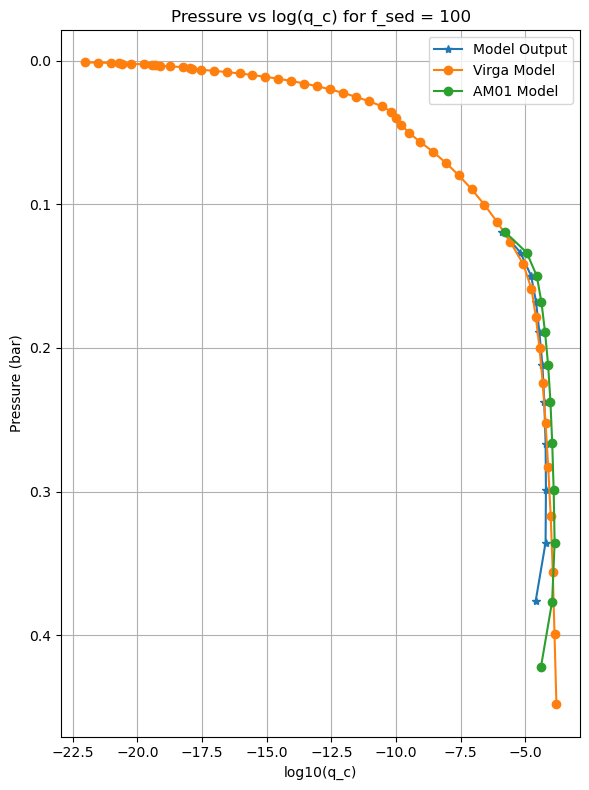

In [225]:
qc_virga = output_virga['condensate_mmr']
P_virga = output_virga['pressure']

# Limit P_virga and qc_virga arrays
P_virga = P_virga[P_virga <= 0.45]
qc_virga = qc_virga[:len(P_virga)]

plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
plt.plot(np.log10(qc_virga), P_virga, marker='o', label='Virga Model')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c) for f_sed = 100")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting AM01 and our model
This one plots AM01 and our model

/tmp/ipykernel_12374/4177959742.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
/tmp/ipykernel_12374/4177959742.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')


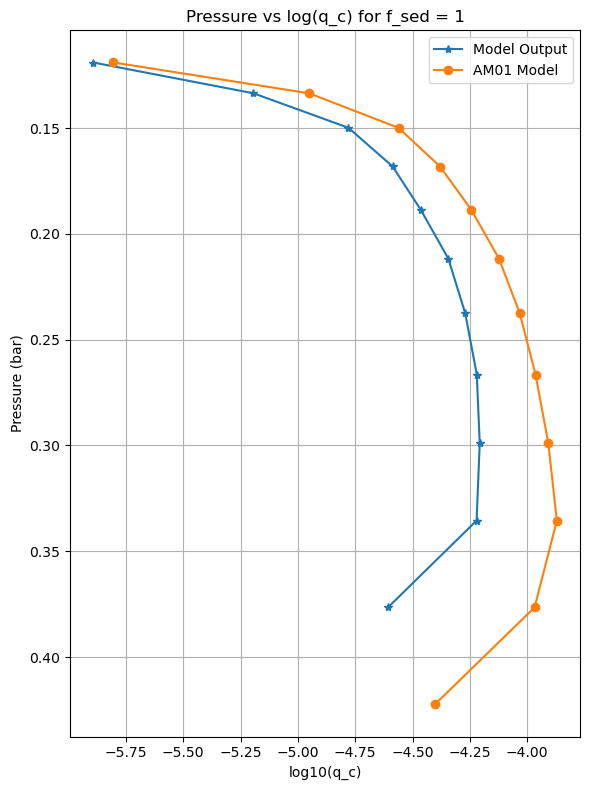

In [226]:
plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), p_layers, marker='*',label='Model Output')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o' ,label='AM01 Model')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  # assuming pressure in bar (confirm units)
plt.title("Pressure vs log(q_c) for f_sed = 1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Saving output as a text file
The output of running thr eddysed_lh function is saved as a txt. file

In [227]:
import numpy as np

# --- Load input profile ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# --- Run eddysed_lh model ---
f_sed = 10
sig = np.ones(num_layers)

kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
    gravity, T_eff, num_layers, sig, f_sed,
    z_layers, p_layers, t_layers, dlnp_layers,
    chf, lapse_ratio,
    gas_name="NH3", gas_mmr=1.34e-4,
    mw_atmos=2.2, rho_p=0.84
)

# --- Save to text file ---
output_filename = f"eddysed_lh_outputs_fsed{f_sed}.txt"

with open(output_filename, "w") as f:
    f.write(f"# Outputs from eddysed_lh (f_sed = {f_sed})\n")
    f.write("# Columns: P(bar), z(m), Kz(cm^2/s), LHF, qt, qc, ndz(cm^-3), rg(cm), reff(cm), rw(cm)\n")
    for i in range(num_layers):
        f.write(f"{p_layers[i]:.5e}\t{z_layers[i]:.5e}\t{kz[i]:.5e}\t{lhf[i]:.5e}\t"
                f"{qt[i]:.5e}\t{qc[i]:.5e}\t{ndz[i]:.5e}\t{rg[i]:.5e}\t"
                f"{reff[i]:.5e}\t{rw[i]:.5e}\n")

print(f"✅ Output saved to {output_filename}")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 7.3614918541847955e-06 g/m^2
✅ Output saved to eddysed_lh_outputs_fsed10.txt


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)


In [228]:
#print (qc)
#print (qt)

# Saving Output as a csv file
The output of running thr eddysed_lh function is saved as a csv. file

In [229]:
import numpy as np
import pandas as pd

# --- Load input profile ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# --- Run eddysed_lh model ---
f_sed = 1.0
sig = np.ones(num_layers)

kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
    gravity, T_eff, num_layers, sig, f_sed,
    z_layers, p_layers, t_layers, dlnp_layers,
    chf, lapse_ratio,
    gas_name="NH3", gas_mmr=1.34e-4,
    mw_atmos=2.2, rho_p=0.84
)

# --- Combine results into a DataFrame ---
df = pd.DataFrame({
    "P_bar": p_layers,         # pressure (bar)
    "z_m": z_layers,           # altitude (m)
    "Kz_cm2_s": kz,            # eddy diffusion coefficient (cm^2/s)
    "LHF": lhf,                # latent heat flux
    "qt": qt,                  # total mixing ratio
    "qc": qc,                  # condensate mixing ratio
    "ndz_cm3": ndz,            # number density (cm^-3)
    "rg_cm": rg,               # geometric mean radius (cm)
    "reff_cm": reff,           # effective radius (cm)
    "rw_cm": rw                # condensate radius (cm)
})

# --- Save to CSV ---
output_filename = "eddysed_lh_outputs_fsed1.csv"
df.to_csv(output_filename, index=False, float_format="%.5e")

print(f"✅ Output saved to {output_filename}")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 4.641045743793291e-05 g/m^2
✅ Output saved to eddysed_lh_outputs_fsed1.csv


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)
/tmp/ipykernel_12374/3736784448.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), (p_layers), marker='*', label=f"Our Model (f_sed={f_sed})")
/tmp/ipykernel_12374/3736784448.py:57: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc_voyager), p_voyager, marker='o', linestyle='--', label=f"AM01 Voyager (f_sed={f_sed})")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 6.59701388874339e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 4.641045743793291e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 2.1130830114798545e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 7.3614918541847955e-06 g/m^2


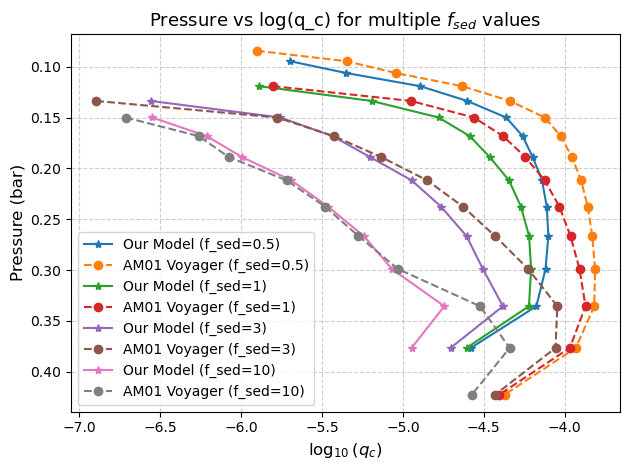

In [230]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
def read_voyager_output(file_path):
    """Reads AM01 (Voyager) .out files, skipping first 3 header lines."""
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            # convert each part to float, handling 'E' notation
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1: "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3: "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10: "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}


# --- Define f_sed values ---
f_sed_values = [0.5, 1, 3, 10]

# Dictionary to store qc arrays
qc_dict = {}

# --- Run the eddysed_lh model for each f_sed value ---
for i, f_sed in enumerate(f_sed_values, start=1):
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )

    # Store qc for plotting
    qc_dict[f_sed] = qc

for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    
    voyager_data = read_voyager_output(voyager_files[f_sed])
    # Column convention from AM01 output: 
    # 0 = layer index?, 1 = pressure(μbar?), 4 = q_c (approximate)
    # Adjust pressure to bar if needed (e.g., 1 μbar = 1e-6 bar)
    p_voyager = voyager_data[:, 1] * 1e-6
    qc_voyager = voyager_data[:, 4]

    plt.plot(np.log10(qc), (p_layers), marker='*', label=f"Our Model (f_sed={f_sed})")
    plt.plot(np.log10(qc_voyager), p_voyager, marker='o', linestyle='--', label=f"AM01 Voyager (f_sed={f_sed})")
# --- Load Voyager reference data using the same reader ---

# --- Plot all models together ---
# plt.figure(figsize=(6, 8))
# --- Formatting ---
plt.gca().invert_yaxis()
plt.xlabel(r"$\log_{10}(q_c)$", fontsize=12)
plt.ylabel("Pressure (bar)", fontsize=12)
plt.title("Pressure vs log(q_c) for multiple $f_{sed}$ values", fontsize=13)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)
/tmp/ipykernel_12374/527728912.py:69: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc), p_layers,color=colors[f_sed], linestyle='-', label=f"Our Model ({f_sed})")
/tmp/ipykernel_12374/527728912.py:70: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc_voyager), p_voyager, color=colors[f_sed], linestyle='--', label=f"AM01 ({f_sed})")


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 6.59701388874339e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 4.641045743793291e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 2.1130830114798545e-05 g/m^2
eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 7.3614918541847955e-06 g/m^2


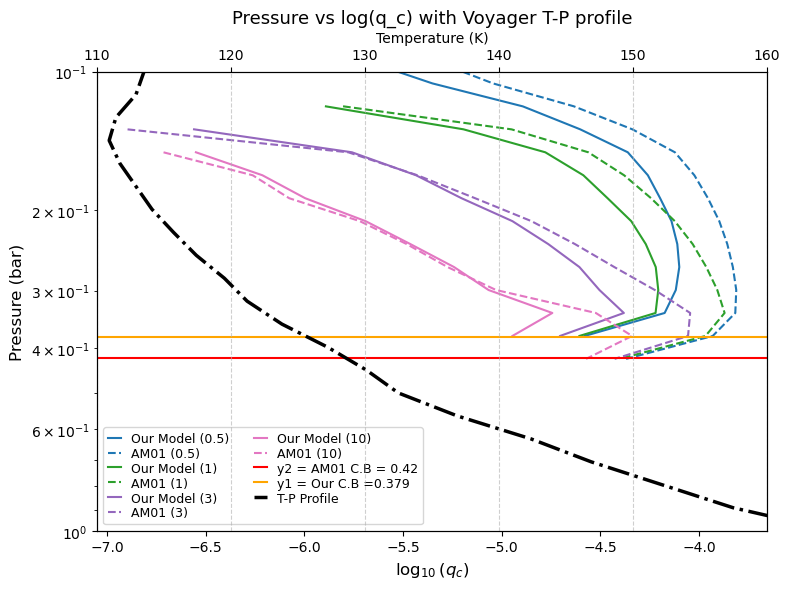

In [231]:
# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
def read_voyager_output(file_path):
    """Reads AM01 (Voyager) .out files, skipping first 3 header lines."""
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            # convert each part to float, handling 'E' notation
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1: "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3: "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10: "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}


# --- Define f_sed values ---
f_sed_values = [0.5, 1, 3, 10]
colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}


# Dictionary to store qc arrays
qc_dict = {}

# --- Run the eddysed_lh model for each f_sed value ---
for i, f_sed in enumerate(f_sed_values, start=1):
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )

    # Store qc for plotting
    qc_dict[f_sed] = qc

for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    
    voyager_data = read_voyager_output(voyager_files[f_sed])
    # Column convention from AM01 output: 
    # 0 = layer index?, 1 = pressure(μbar?), 4 = q_c (approximate)
    # Adjust pressure to bar if needed (e.g., 1 μbar = 1e-6 bar)
    p_voyager = voyager_data[:, 1] * 1e-6
    qc_voyager = voyager_data[:, 4]
# --- Plot all models together ---
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot model vs Voyager data
for f_sed in f_sed_values:
    qc = qc_dict[f_sed]
    voyager_data = read_voyager_output(voyager_files[f_sed])
    p_voyager = voyager_data[:, 1] * 1e-6  # μbar → bar
    qc_voyager = voyager_data[:, 4]

    ax1.plot(np.log10(qc), p_layers,color=colors[f_sed], linestyle='-', label=f"Our Model ({f_sed})")
    ax1.plot(np.log10(qc_voyager), p_voyager, color=colors[f_sed], linestyle='--', label=f"AM01 ({f_sed})")

# --- Add T–P profile on top axis ---
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()
    T_eff = float(lines[0])
    gravity = float(lines[1])
    num_layer_edges = int(lines[2])
    for line in lines[4:]:
        parts = line.strip().split()
        input_data.append([float(x.replace("E", "e")) for x in parts])
input_array = np.array(input_data)
t_layer_edges = input_array[:, 0]  # Temperature (K)
p_layer_edges = input_array[:, 1]  # Pressure (bar)

# Create twin x-axis for temperature
ax2 = ax1.twiny()
ax2.plot(t_layer_edges, p_layer_edges, color='black',linestyle='-.', lw=2.5, label="T-P Profile")
ax2.set_xlabel("Temperature (K)")
ax2.grid(False)

# Give temperature axis independent limits
ax2.set_xlim(110, 160)  # adjust as needed to match your T range


# --- Formatting ---
ax1.set_yscale("log")        # Logarithmic pressure axis
ax1.invert_yaxis() 
   # Keep downward pressure orientation
ax1.set_xlabel(r"$\log_{10}(q_c)$", fontsize=12)
ax1.set_ylabel("Pressure (bar)", fontsize=12)
ax1.set_title("Pressure vs log(q_c) with Voyager T-P profile", fontsize=13)
#ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.axhline(y=0.42, color='red', linestyle='-', lw=1.5, label="y2 = AM01 C.B = 0.42")
ax1.axhline(y=0.379, color='orange', linestyle='-', lw=1.5, label="y1 = Our C.B =0.379")
ax1.set_ylim(1, 0.1) 
# Combine legends (for both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower left")
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower left",
    fontsize=9,
    labelspacing=0.15,
    handlelength=1.0,
    ncol=2
)
ax1.ticklabel_format(axis='x', style='plain')


plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1058: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, cov = optimize.curve_fit(f=pow_law, xdata=r_, ydata=np.log(vfall_temp), p0=[0],
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1071: RuntimeWarning: divide by zero encountered in scalar divide
  rg_layer = (fsed_mid**(1./alpha) *
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  ndz_layer = (3*rho_atmos*qc_layer*dz_layer /


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 6.59701388874339e-05 g/m^2


/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:257: RuntimeWarning: divide by zero encountered in log10
  if np.log10(rg[iz,igas]) < np.log10(rmin)+0.75*sig:
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:262: RuntimeWarning: invalid value encountered in scalar multiply
  opd_layer[iz,igas] = 2.*PI*r2*ndz[iz,igas]
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  arg2 = -np.log( rr/rg[iz,igas] )**2 / ( 2*np.log(rsig)**2 )
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:280: RuntimeWarning: divide by zero encountered in scalar divide
  arg2 = -np.log( rr/rg[iz,igas] )**2 / ( 2*np.log(rsig)**2 )
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:281: RuntimeWarning: invalid value encountered in scalar multiply
  pir2ndz = norm*PI*rr*arg1*np.exp( arg2 )


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 4.641045743793291e-05 g/m^2


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1058: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, cov = optimize.curve_fit(f=pow_law, xdata=r_, ydata=np.log(vfall_temp), p0=[0],
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1071: RuntimeWarning: divide by zero encountered in scalar divide
  rg_layer = (fsed_mid**(1./alpha) *


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 2.1130830114798545e-05 g/m^2


/tmp/ipykernel_12374/750460387.py:148: RuntimeWarning: invalid value encountered in scalar power
  w_convect = (-coeff_b/2 + np.sqrt(cubic_arg))**(1/3) + (-coeff_b/2 - np.sqrt(cubic_arg))**(1/3)
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1058: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, cov = optimize.curve_fit(f=pow_law, xdata=r_, ydata=np.log(vfall_temp), p0=[0],
/home/sansar1/miniconda3/envs/cloud/lib/python3.13/site-packages/virga/justdoit.py:1071: RuntimeWarning: divide by zero encountered in scalar divide
  rg_layer = (fsed_mid**(1./alpha) *


eddysed(): condensing gas = NH3
T(cloud_base) = 125.54891000254703
opd_expect = nan
eddysed(): condensing gas = NH3
condensate path = 7.3614918541847955e-06 g/m^2


/tmp/ipykernel_12374/80597455.py:94: RuntimeWarning: divide by zero encountered in log10
  np.log10(qc_dict[f_sed]), p_layers,


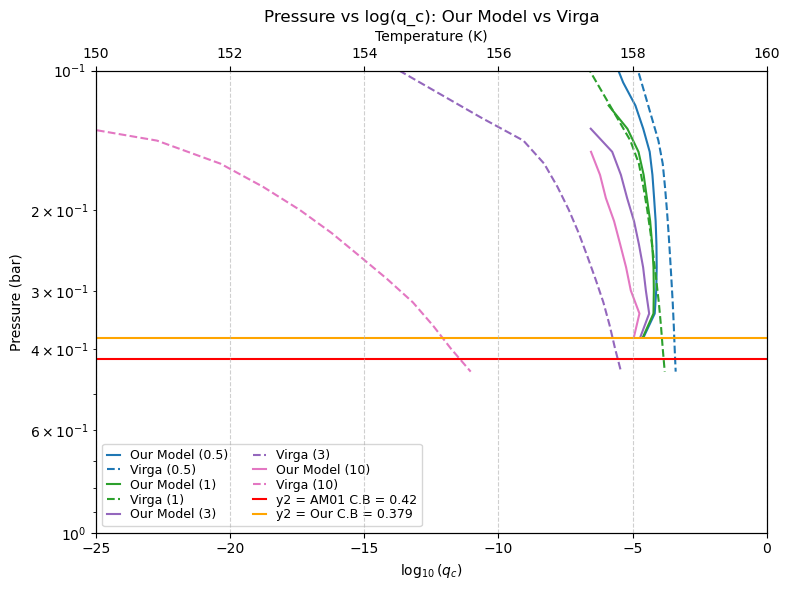

In [232]:
# --- Load input profile using the voyager reader ---
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

import virga.justdoit as jdi
import astropy.units as u
import pandas as pd


# --- f_sed values and colors ---
f_sed_values = [0.5, 1, 3, 10]
colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}

qc_dict = {}
virga_qc_dict = {}
virga_p_dict = {}

# --- RUN OUR MODEL + VIRGA MODEL ---
for f_sed in f_sed_values:

    # -------------------------
    # 1. Our Model (eddysed_lh)
    # -------------------------
    sig = np.ones(num_layers)
    kz, lhf, qt, qc, ndz, rg, reff, rw = eddysed_lh(
        gravity, T_eff, num_layers, sig, f_sed,
        z_layers, p_layers, t_layers, dlnp_layers,
        chf, lapse_ratio,
        gas_name="NH3", gas_mmr=1.34e-4,
        mw_atmos=2.2, rho_p=0.84
    )

    qc_dict[f_sed] = qc


    # -------------------------
    # 2. VIRGA MODEL
    # -------------------------
    t = t_layers
    p = p_layers
    z = z_layers
    mixl = chf * np.ones_like(t)
    kz_arr = kz

    df = pd.DataFrame({
        "temperature": t,
        "pressure": p,
        "altitude": z,
        "mixing_length": mixl,
        "kz": kz_arr,
        "chf": chf * np.ones_like(t)
    })

    atmos = jdi.Atmosphere(["NH3"], fsed=f_sed)
    cmps2 = u.cm / (u.s**2)
    atmos.gravity(gravity=gravity, gravity_unit=cmps2)
    atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat=True)

    output_virga = jdi.compute(
        atmo=atmos,
        directory='/home/sansar1/Codes/cloud_model/input/optics'
    )

    qc_virga = np.array(output_virga["condensate_mmr"])
    p_virga = np.array(output_virga["pressure"])

    # Limit pressure range to ≤ 0.45 bar
    mask = p_virga <= 0.45
    p_virga = p_virga[mask]
    qc_virga = qc_virga[mask]

    virga_p_dict[f_sed] = p_virga
    virga_qc_dict[f_sed] = qc_virga



# ===============================================================
#                      PLOTTING SECTION
# ===============================================================

fig, ax1 = plt.subplots(figsize=(8, 6))

# ---------- PLOT OUR MODEL + VIRGA MODEL ----------
for f_sed in f_sed_values:

    # Our Model
    ax1.plot(
        np.log10(qc_dict[f_sed]), p_layers,
        color=colors[f_sed], linestyle='-',
        label=f"Our Model ({f_sed})"
    )

    # VIRGA Model
    ax1.plot(
        np.log10(virga_qc_dict[f_sed]), virga_p_dict[f_sed],
        color=colors[f_sed], linestyle='--',
        label=f"Virga ({f_sed})"
    )


# ---------- T–P PROFILE ----------
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()[4:]
    for line in lines:
        input_data.append([float(x.replace("E", "e")) for x in line.split()])
input_array = np.array(input_data)

t_layer_edges = input_array[:, 0]
p_layer_edges = input_array[:, 1]

ax2 = ax1.twiny()
#ax2.plot(t_layer_edges, p_layer_edges,
         #color='black', linestyle='-.', lw=2.5, label="T-P Profile")
ax2.set_xlabel("Temperature (K)")
ax2.set_xlim(150, 160)
ax1.set_xlim(-25,0)
ax2.grid(False)


# ---------- FORMATTING ----------
ax1.set_yscale("log")
ax1.invert_yaxis()
ax1.set_ylim(1, 0.1)   # restrict to 0.1–1 bar
ax1.set_xlabel(r"$\log_{10}(q_c)$")
ax1.set_ylabel("Pressure (bar)")
ax1.set_title("Pressure vs log(q_c): Our Model vs Virga")

ax1.axhline(y=0.42, color='red', lw=1.5, label="y2 = AM01 C.B = 0.42")
ax1.axhline(y=0.379, color='orange', lw=1.5, label="y2 = Our C.B = 0.379")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="lower left",
           fontsize=9, labelspacing=0.15,
           handlelength=1.0, ncol=2)

# No scientific notation on x-axis
ax1.ticklabel_format(axis='x', style='plain')

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_12374/1645149083.py:91: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(qc_am), p_am, color=colors[fsed],


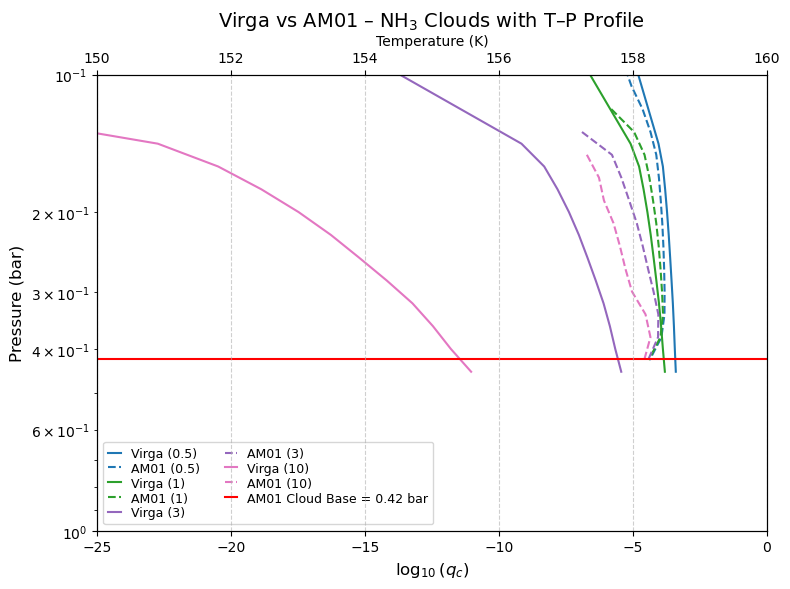

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import virga.justdoit as jdi
import astropy.units as u

# ===============================================================
#                   READ VOYAGER INPUT PROFILE
# ===============================================================
gravity, T_eff, num_layer_edges, p_layer_edges, t_layer_edges, z_layer_edges, \
num_layers, p_layers, t_layers, z_layers, chf, dlnp_layers, lapse_ratio = \
    read_voyager_lh("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")

# ===============================================================
#              FUNCTION: READ VOYAGER AM01 OUTPUT FILES
# ===============================================================
def read_voyager_output(file_path):
    voyager = []
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines[3:]:
            parts = line.strip().split()
            voyager.append([float(x.replace("E", "e")) for x in parts])
    return np.array(voyager)

# Voyager AM01 output files for each f_sed
voyager_files = {
    0.5: "/home/sansar1/Codes/cloud_model/output/voyager_frain0.5_sig2.out",
    1:   "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out",
    3:   "/home/sansar1/Codes/cloud_model/output/voyager_frain3_sig2.out",
    10:  "/home/sansar1/Codes/cloud_model/output/voyager_frain10_sig2.out"
}

f_sed_values = [0.5, 1, 3, 10]

colors = {
    0.5: "tab:blue",
    1:   "tab:green",
    3:   "tab:purple",
    10:  "tab:pink"
}

# ===============================================================
#          COMPUTE VIRGA MODEL FOR ALL f_sed VALUES
# ===============================================================
virga_qc_dict = {}
virga_p_dict = {}

for fsed in f_sed_values:

    data = np.column_stack((t_layers, p_layers, z_layers,
                            np.zeros_like(t_layers),
                            np.zeros_like(t_layers),
                            chf))

    df = pd.DataFrame(data, columns=['temperature','pressure','altitude',
                                     'mixing_length','kz','chf'])

    atmos = jdi.Atmosphere(['NH3'], fsed=fsed)
    atmos.gravity(gravity=gravity, gravity_unit=u.cm/u.s**2)
    atmos.ptk(df=df, Teff=T_eff, convective_overshoot=1/3, latent_heat=True)

    output_virga = jdi.compute(atmo=atmos,
                directory='/home/sansar1/Codes/cloud_model/input/optics')

    qc_virga = np.array(output_virga['condensate_mmr'])
    P_virga = np.array(output_virga['pressure'])

    mask = P_virga <= 0.45
    virga_qc_dict[fsed] = qc_virga[mask]
    virga_p_dict[fsed]  = P_virga[mask]

# ===============================================================
#                  BEGIN PLOTTING
# ===============================================================
fig, ax1 = plt.subplots(figsize=(8, 6))

# ---- VIRGA vs AM01 plots ----
for fsed in f_sed_values:

    qc_v = virga_qc_dict[fsed]
    p_v = virga_p_dict[fsed]

    voy = read_voyager_output(voyager_files[fsed])
    p_am = voy[:, 1] * 1e-6
    qc_am = voy[:, 4]

    ax1.plot(np.log10(qc_v), p_v, color=colors[fsed],
             linestyle='-', label=f"Virga ({fsed})")

    ax1.plot(np.log10(qc_am), p_am, color=colors[fsed],
             linestyle='--', label=f"AM01 ({fsed})")

# ===============================================================
#              ADD T-P PROFILE ON TOP AXIS
# ===============================================================
input_file = "/home/sansar1/Codes/cloud_model/input/profiles/voyager.input"
input_data = []
with open(input_file, "r") as f:
    lines = f.readlines()
    Teff = float(lines[0])
    grav = float(lines[1])
    nedge = int(lines[2])
    for line in lines[4:]:
        parts = line.strip().split()
        input_data.append([float(x.replace("E","e")) for x in parts])

input_array = np.array(input_data)
T_prof = input_array[:, 0]
P_prof = input_array[:, 1]

ax2 = ax1.twiny()
#ax2.plot(T_prof, P_prof, color='black', linestyle='-.', lw=2.5,
         #label="T–P Profile")

ax2.set_xlabel("Temperature (K)")
ax2.grid(False)
ax2.set_xlim(150, 160)
ax1.set_xlim (-25,0)

# ===============================================================
#    Formatting: log pressure, cloud base lines, legend, etc.
# ===============================================================
ax1.set_yscale("log")
ax1.invert_yaxis()
ax1.set_ylim(1, 0.1)

ax1.set_xlabel(r"$\log_{10}(q_c)$", fontsize=12)
ax1.set_ylabel("Pressure (bar)", fontsize=12)
ax1.set_title("Virga vs AM01 – NH$_3$ Clouds with T–P Profile", fontsize=14)

ax1.axhline(0.42, color='red', linestyle='-', lw=1.5, label="AM01 Cloud Base = 0.42 bar")
#ax1.axhline(0.379, color='orange', linestyle='-', lw=1.5, label="Virga Cloud Base = 0.379 bar")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2,
           labels1 + labels2,
           loc="lower left",
           fontsize=9,
           labelspacing=0.15,
           handlelength=1.0,
           ncol=2)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
